# FPR, FNR, AND ACCURACY

*Import Libraries*

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import re
import string
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Load Data*

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/RDS Final Project/jigsaw-unintended-bias-in-toxicity-classification (1)/test_private_expanded.csv')
train = pd.read_csv('/content/drive/MyDrive/RDS Final Project/jigsaw-unintended-bias-in-toxicity-classification (1)/train.csv')
pred = pd.read_csv('/content/drive/MyDrive/RDS Final Project/jigsaw-unintended-bias-in-toxicity-classification (1)/submission.csv')


Apply same cleaning and preprocessing methods

In [ ]:
id_test = test.columns[21:45]
#set initial boolean array
label = pd.Series([True for i in range(len(test))])

# for every identity, sees which lines are valid,
# save results in the boolean array 'label'
for i in id_test:
  label = label & (pd.notnull(test[i]))

test_clean = test[label]

In [ ]:
text = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return text.sub(r' \1 ', s).split()
length = train.shape[0]
Vectorize = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

In [ ]:
ads_test = Vectorize.fit_transform(test_clean["comment_text"])

In [ ]:
ads_test

<21577x92730 sparse matrix of type '<class 'numpy.float64'>'
	with 2041601 stored elements in Compressed Sparse Row format>

In [ ]:
ads_test = pd.DataFrame(ads_test)
ads_test.rename(columns = {0: "comment_text_preprocessed"}, 
          inplace = True)
ads_test.head()

,comment_text_preprocessed
0,"(0, 51752)\t0.29174013946685257\n (0, 58930..."
1,"(0, 4197)\t0.11110084003103093\n (0, 41610)..."
2,"(0, 54019)\t0.34424830845672777\n (0, 86895..."
3,"(0, 17206)\t0.14755356550105467\n (0, 70246..."
4,"(0, 85776)\t0.1017023804088463\n (0, 44453)..."


*Create Cleaned Dataset for Predictions Data*

In [ ]:
test_clean_index = np.array(test_clean.index)
len(test_clean_index)
preds_clean = pred.loc[test_clean_index, :]

*Binary Classification for Toxicity*

In [ ]:

preds_clean.loc[preds_clean['prediction'] <= 0.5, 'prediction'] = 0
preds_clean.loc[preds_clean['prediction'] > 0.5, 'prediction'] = 1

test_clean.loc[test_clean['toxicity'] <= 0.5, 'toxicity'] = 0
test_clean.loc[test_clean['toxicity'] > 0.5, 'toxicity'] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


*DataFrame Manipulation to join features*

In [ ]:
final_df = pd.DataFrame(test_clean[['id','comment_text','male','female','homosexual_gay_or_lesbian','white','black']])
temp = pd.DataFrame(preds_clean['prediction'])
temp3 = pd.DataFrame(test_clean['toxicity'])
temp2 = pd.DataFrame(ads_test['comment_text_preprocessed'])
final_df = final_df.join(temp)
final_df = final_df.join(temp3)
final_df = final_df.join(temp2)
final_df.head()

,id,comment_text,male,female,homosexual_gay_or_lesbian,white,black,prediction,toxicity,comment_text_preprocessed
1,7097321,This is malfeasance by the Administrator and t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(0, 4197)\t0.11110084003103093\n (0, 41610)..."
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(0, 54019)\t0.34424830845672777\n (0, 86895..."
15,7097335,IT IS DOA! As Collins announced her intentions...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(0, 50296)\t0.06078852776701302\n (0, 48551..."
21,7097341,It's a black mark on the previous administrati...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,"(0, 47921)\t0.151974215194401\n (0, 56223)\..."
37,7097357,Don’t get it do you. As the price of things go...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(0, 4768)\t0.05760673476823981\n (0, 42934)..."


In [ ]:

# get the overall performance metrics of the classifer
print("accuracy:", metrics.accuracy_score(final_df['prediction'], final_df['toxicity']))
print("AUC:", metrics.roc_auc_score(final_df['prediction'], final_df['toxicity']))
print('precision:', metrics.precision_score(final_df['prediction'], final_df['toxicity']))
print('recall:', metrics.recall_score(final_df['prediction'], final_df['toxicity']))
print('average_precision:', metrics.average_precision_score(final_df['prediction'], final_df['toxicity']))

accuracy: 0.943782731612365
AUC: 0.817189738265141
precision: 0.5771694816540478
recall: 0.6705006765899865
average_precision: 0.40956285747367266


overall false postive rate 0.027906976744186043
overall true postive rate 0.7441860465116279
overall false negative rate 0.2558139534883721
overall true negative rate 0.9490084985835694


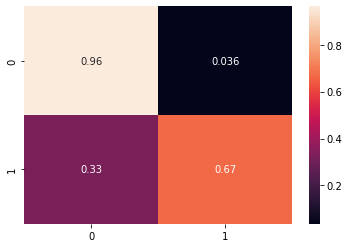

In [ ]:
cf_matrix = metrics.confusion_matrix(final_df['prediction'], final_df['toxicity'],normalize='true')
cf_matrix = pd.DataFrame(cf_matrix)
tp = .96
fp = .036
fn = 0.33
tn = 0.67
overall_fpr = fp/(tp+fn)
overall_tpr = tp/(tp+fn)
overall_fnr = fn/(fn+tp)
overall_tnr = tn/(tn+fp)
print('overall false postive rate',overall_fpr)
print('overall true postive rate',overall_tpr)
print('overall false negative rate',overall_fnr)
print('overall true negative rate',overall_tnr)
sns.heatmap(cf_matrix, annot = True)


# Sex

*Here we will calculate FPR, FNR, and Accuracy for males and females*

In [ ]:
final_df["male"].mean()

mask = final_df["male"] > 0.1

print(pd.crosstab(final_df.loc[mask, "toxicity"],
                  final_df.loc[mask, "prediction"]))
print("Privileged group (male)",'\n')

tp = 22
fp = 249
tn = 2889
fn = 341

pred_fav_male = tn+fn
total_male = tp + fp + tn + fn 

fpr_male = fp / (fp + tn) * 100
fnr_male = fn / (fn + tp) * 100

print("False positive rate", fpr_male)
print("False negative rate", fnr_male)
acc_male = (tp+tn)/total_male
print("Accuracy",acc_male)

prediction   0.0  1.0
toxicity             
0.0         3025  123
1.0          147  216
Privileged group (male) 

False positive rate 7.934990439770555
False negative rate 93.93939393939394
Accuracy 0.8314767209368752


In [ ]:
mask = final_df["female"] > .1

print(pd.crosstab(final_df.loc[mask, "toxicity"],
                  final_df.loc[mask, "prediction"]))
print("Unprivileged group (female)",'\n')

tp = 24
fp = 250
tn = 2877
fn = 303

pred_fav_female = tn+fn
total_female = tp + fp + tn + fn 

fpr_female = fp / (fp + tn) * 100
fnr_female = fn / (fn + tp) * 100

print("False positive rate", fpr_female)
print("False negative rate", fnr_female)
acc_female = (tp+tn)/total_female
print("Accuracy",acc_female)

prediction   0.0  1.0
toxicity             
0.0         3036   91
1.0          134  193
Unprivileged group (female) 

False positive rate 7.99488327470419
False negative rate 92.66055045871559
Accuracy 0.8398957730167921


In this case the favorable results (male) is not toxic. 

In [ ]:
priv_favorable = (pred_fav_male/total_male)*100
unpriv_favorable = (pred_fav_female/total_female)*100

print("Mean Outcomes-Gender:",unpriv_favorable-priv_favorable)

Mean Outcomes-Gender: -0.19218596986186753


## Disparate Impact (DI)

In [ ]:
gender_di = pred_fav_female/pred_fav_male
print('Disparate Impact - Males/Females:', gender_di)

Disparate Impact - Males/Females: 0.9845201238390093


## Equalized Odds between protected (male) and unprotected (female) groups. These should have the same TP and FP rates

In [ ]:
print("Unprivileged Group:FEMALE")
print("False positive rate", fpr_female)
print("False negative rate", fnr_female)

print('\n',"Privileged group:MALE")
print("False positive rate", fpr_male)
print("False negative rate", fnr_male)

print('\n',"FPR Difference", fpr_female-fpr_male)
print("FNR Difference", fnr_female-fnr_male)

Unprivileged Group:FEMALE
False positive rate 7.99488327470419
False negative rate 92.66055045871559

 Privileged group:MALE
False positive rate 7.934990439770555
False negative rate 93.93939393939394

 FPR Difference 0.05989283493363473
FNR Difference -1.278843480678347


# Race

Here we will calculate FPR, FNR, and Accuracy for black and white individuals

*Black*

In [ ]:
final_df["black"].mean()

mask = final_df["black"] > 0.03

print(pd.crosstab(final_df.loc[mask, "toxicity"],
                  final_df.loc[mask, "prediction"]))
print("Unprivileged group (black)",'\n')

tp = 8
fp = 51
tn = 744
fn = 186

pred_fav_black= tn+fn
total_black = tp + fp + tn + fn

fpr_black = fp / (fp + tn) * 100
fnr_black = fn / (fn + tp) * 100

print("False positive rate", fpr_black)
print("False negative rate", fnr_black)
acc_black = (tp+tn)/total_black
print("Accuracy",acc_black)

prediction  0.0  1.0
toxicity            
0.0         723   72
1.0          94  100
Unprivileged group (black) 

False positive rate 6.415094339622642
False negative rate 95.87628865979381
Accuracy 0.7603640040444893


*White*

In [ ]:
final_df["white"].mean()

mask = final_df["white"] > 0.05

print(pd.crosstab(final_df.loc[mask, "toxicity"],
                  final_df.loc[mask, "prediction"]))
print("privileged group (white)",'\n')

tp = 18
fp = 98
tn = 1065
fn = 246

pred_fav_white= tn+fn
total_white = tp + fp + tn + fn

fpr_white = fp / (fp + tn) * 100
fnr_white = fn / (fn + tp) * 100

print("False positive rate", fpr_white)
print("False negative rate", fnr_white)
acc_white = (tp+tn)/total_white
print("Accuracy",acc_white)

prediction   0.0  1.0
toxicity             
0.0         1042  121
1.0          120  144
privileged group (white) 

False positive rate 8.426483233018056
False negative rate 93.18181818181817
Accuracy 0.7589348283111422


*Mean Outcomes*

In [ ]:
unpriv_favorable = (pred_fav_black/total_black)*100
privileged_favorable = (pred_fav_white/total_white)*100

print("Mean Outcomes - Race:",unpriv_favorable-privileged_favorable)

Mean Outcomes - Race: 2.163319995776945


*Disparate Impact*

In [ ]:
race_di = pred_fav_black/pred_fav_white
print('disparate impact:', race_di)

disparate impact: 0.7093821510297483


*Equalized Odds*

In [ ]:
print("Unprivileged group: BLACK")
print("False positive rate", fpr_black)
print("False negative rate", fnr_black)

print('\n',"Privileged group: WHITE")
print("False positive rate", fpr_white)
print("False negative rate", fnr_white)

print('\n',"FPR Difference", fpr_black-fpr_white)
print("FNR Difference", fnr_black-fnr_white)

Unprivileged group: BLACK
False positive rate 6.415094339622642
False negative rate 95.87628865979381

 Privileged group: WHITE
False positive rate 8.426483233018056
False negative rate 93.18181818181817

 FPR Difference -2.011388893395414
FNR Difference 2.694470477975642


# Sexual Orientation

FPR, FNR, and Accuracy

In [ ]:
final_df["homosexual_gay_or_lesbian"].mean()

mask = final_df["homosexual_gay_or_lesbian"] > 0.02

print(pd.crosstab(final_df.loc[mask, "toxicity"],
                  final_df.loc[mask, "prediction"]))
print("Unprivileged group ()",'\n')

tp = 13
fp = 60
tn = 551
fn = 104

pred_fav_homo = tn+fn
total_homo = tp + fp + tn + fn

fpr_homo = fp / (fp + tn) * 100
fnr_homo = fn / (fn + tp) * 100

print("False positive rate", fpr_homo)
print("False negative rate", fnr_homo)
acc_homo = (tp+tn)/total_homo
print("Accuracy",acc_homo)

prediction  0.0  1.0
toxicity            
0.0         550   61
1.0          65   52
Unprivileged group () 

False positive rate 9.819967266775777
False negative rate 88.88888888888889
Accuracy 0.7747252747252747


In [ ]:
mask = final_df["homosexual_gay_or_lesbian"] <= 0.02

print(pd.crosstab(final_df.loc[mask, "toxicity"],
                  final_df.loc[mask, "prediction"]))
print("Privileged group ()",'\n')

tp = 26
fp = 1587
tn = 17662
fn = 1474

pred_fav_nohomo = tn+fn
total_nohomo = tp + fp + tn + fn

fpr_nohomo = fp / (fp + tn) * 100
fnr_nohomo = fn / (fn +tp ) * 100

print("False positive rate", fpr_nohomo)
print("False negative rate", fnr_nohomo)
acc_nohomo = (tp+tn)/total_nohomo
print("Accuracy",acc_nohomo)

prediction    0.0  1.0
toxicity              
0.0         18823  426
1.0           661  939
Privileged group () 

False positive rate 8.244584134240739
False negative rate 98.26666666666667
Accuracy 0.8524748180635211


*Mean Outcome for Sexual Orientation*

In [ ]:
unpriv_favorable = (pred_fav_homo/total_homo)*100
privileged_favorable = (pred_fav_nohomo/total_nohomo)*100

print("Mean Outcomes (favorable=non toxic prediction):",unpriv_favorable-privileged_favorable)

Mean Outcomes (favorable=non toxic prediction): -2.253603907298057


*Disparate Impact*

In [ ]:
sexual_orientation_di = pred_fav_homo/pred_fav_nohomo
print('disparate impact:', sexual_orientation_di)

disparate impact: 0.03422867892976589


*Equalized Odds*

In [ ]:
print("Unprivileged group: HOMOSEXUAL")
print("False positive rate", fpr_homo)
print("False negative rate", fnr_homo)

print('\n',"Privileged group: NON-HOMOSEXUAL")
print("False positive rate", fpr_nohomo)
print("False negative rate", fnr_nohomo)

print('\n',"FPR Difference", fpr_homo-fpr_nohomo)
print("FNR Difference", fnr_homo-fnr_nohomo)

Unprivileged group: HOMOSEXUAL
False positive rate 9.819967266775777
False negative rate 88.88888888888889

 Privileged group: NON-HOMOSEXUAL
False positive rate 8.244584134240739
False negative rate 98.26666666666667

 FPR Difference 1.5753831325350376
FNR Difference -9.37777777777778


In [ ]:
male = [fpr_male, fnr_male, acc_male]
female = [fpr_female, fnr_female, acc_female]
black= [fpr_black, fnr_black, acc_black]
white= [fpr_white, fnr_white, acc_white]
homo = [fpr_homo, fnr_homo, acc_homo]
nohomo = [fpr_nohomo, fnr_nohomo, acc_nohomo]

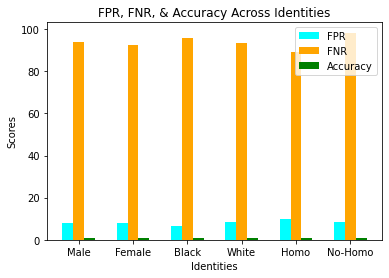

In [ ]:
x = np.arange(6)
labels = ['Male', 'Female', 'Black', 'White', 'Homo', 'No-Homo']
fpr = [male[0], female[0], black[0], white[0], homo[0], nohomo[0]]
fnr = [male[1], female[1], black[1], white[1], homo[1], nohomo[1]]
acc = [male[2], female[2], black[2], white[2], homo[2], nohomo[2]]
width = 0.2


plt.bar(x-.2, fpr, width, color = 'cyan')
plt.bar(x, fnr, width, color = 'orange')
plt.bar(x+.2, acc, width, color = 'green')
plt.xticks(x, ['Male', 'Female', 'Black', 'White', 'Homo', 'No-Homo'])
plt.xlabel("Identities")
plt.ylabel("Scores")
plt.legend(["FPR", "FNR", "Accuracy"])
plt.title('FPR, FNR, & Accuracy Across Identities')
plt.show()